# Tanager calibration candidate check

Use this notebook to pick the brightest and most homogeneous Tanager core-imagery scene for cross-sensor radiometric work (PRISMA/EnMAP/Tanager). The workflow:

- load four candidate HDF5/ZIP deliveries (radiance by default, optionally surface reflectance)
- optionally crop rows (keep **all columns** for pushbroom diagnostics)
- mask nodata/cloud/cirrus pixels using Planet QA layers
- compute brightness and homogeneity metrics per spectral window and across columns
- surface quicklooks, column profiles, and a sortable summary table so you can pick the cleanest scene


In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure repository root is on sys.path so `scripts` can be imported
REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / "scripts").exists():
    REPO_ROOT = REPO_ROOT.parent.resolve()
if not (REPO_ROOT / "scripts").exists():
    raise FileNotFoundError(f"Could not locate repository root from {Path.cwd()}")
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts.satellites import tanager_utils
from scripts.diagnostics import striping

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
pd.set_option("display.max_columns", None)


In [2]:
# --- User configuration ----------------------------------------------------
from pathlib import Path

# Keep radiance by default for cross-sensor comparison. Switch to SR if needed.
DATASET_PATH = tanager_utils.TANAGER_TOA_RADIANCE_DATASET
# DATASET_PATH = tanager_utils.TANAGER_SURFACE_REFLECTANCE_DATASET

# WSL paths to the four candidate scenes (names match parent folders for clarity).
CANDIDATES = {
    "Botswana": Path("/mnt/d/case_studies_tanager/Tanager_Calibration/Botswana/20250829_092903_90_4001/basic_radiance_hdf5__20250829_092903_90_4001_basic_radiance_hdf5.h5"),
    "Senegal": Path("/mnt/d/case_studies_tanager/Tanager_Calibration/Senegal/20250516_121248_87_4001/basic_radiance_hdf5__20250516_121248_87_4001_basic_radiance_hdf5.h5"),
    "Sudan": Path("/mnt/d/case_studies_tanager/Tanager_Calibration/Sudan/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5"),
    "Yemen": Path("/mnt/d/case_studies_tanager/Tanager_Calibration/Yemen/20250608_074757_58_4001/basic_radiance_hdf5__20250608_074757_58_4001_basic_radiance_hdf5.h5"),
}

# Keep all columns; optionally restrict rows to avoid edges/clouds. Examples: None, "50:650", (100, 900)
ROW_SLICE = None

# Spectral windows to score brightness/homogeneity (nm).
BAND_WINDOWS_NM = {
    "CH4_1650": (1600.0, 1700.0),
    "CH4_2300": (2150.0, 2350.0),
    "VIS": (500.0, 700.0),
}

# QA masks to apply (set False to ignore a layer if missing or too aggressive).
MASK_FLAGS = {
    "nodata_pixels": True,
    "beta_cloud_mask": True,
    "beta_cirrus_mask": True,
}

# Maximum size for the RGB quicklook (longest side in pixels).
RGB_MAX_SIZE = 1400


In [3]:
# --- Helper functions ------------------------------------------------------
@dataclass
class CandidateResult:
    name: str
    path: Path
    rows_used: str
    valid_fraction: float
    wavelengths: np.ndarray | None
    spectrum: np.ndarray
    spectrum_wavelengths: np.ndarray | None
    windows: dict
    rgb: np.ndarray

def parse_row_slice(spec, n_rows: int) -> slice:
    if spec is None:
        return slice(0, n_rows)
    if isinstance(spec, slice):
        return spec
    if isinstance(spec, str):
        parts = spec.split(":")
        if len(parts) == 1:
            start = int(parts[0]) if parts[0] else 0
            end = n_rows
        else:
            start = int(parts[0]) if parts[0] else 0
            end = int(parts[1]) if parts[1] else n_rows
        return slice(start, min(end, n_rows))
    if isinstance(spec, (tuple, list)) and len(spec) == 2:
        start = 0 if spec[0] is None else int(spec[0])
        end = n_rows if spec[1] is None else int(spec[1])
        return slice(start, min(end, n_rows))
    raise ValueError(f"Unsupported row slice: {spec}")

def resolve_candidate_paths(candidates: dict[str, Path]) -> dict[str, Path]:
    resolved: dict[str, Path] = {}
    for name, raw in candidates.items():
        path = Path(raw).expanduser()
        if not path.exists():
            print(f"[skip] {name}: missing file -> {path}")
            continue
        if path.suffix.lower() == ".zip":
            extracted = tanager_utils.extract_hdf_from_zip(str(path), str(path.parent))
            if extracted:
                path = Path(extracted)
                print(f"[info] extracted {name} -> {path}")
            else:
                print(f"[skip] {name}: ZIP contains no HDF5 file -> {path}")
                continue
        resolved[name] = path
    if not resolved:
        raise FileNotFoundError("No candidate files found. Update CANDIDATES above.")
    return resolved

def band_indices_for_range(wavelengths: np.ndarray | None, nm_range: tuple[float, float]) -> np.ndarray:
    if wavelengths is None:
        raise ValueError("Wavelength metadata is missing; cannot select band window.")
    lo, hi = nm_range
    idx = np.where((wavelengths >= lo) & (wavelengths <= hi))[0]
    if idx.size == 0:
        raise ValueError(f"No bands within range {nm_range} nm")
    return idx

def summarise_image(img2d: np.ndarray, valid_mask: np.ndarray) -> dict:
    masked = np.where(valid_mask, img2d, np.nan)
    median = float(np.nanmedian(masked))
    mean = float(np.nanmean(masked))
    std = float(np.nanstd(masked))
    cv = std / (median + 1e-6)

    col_median = np.nanmedian(masked, axis=0)
    row_median = np.nanmedian(masked, axis=1)

    col_range_pct = (np.nanmax(col_median) - np.nanmin(col_median)) / (np.nanmedian(col_median) + 1e-6)
    col_cv = float(np.nanstd(col_median) / (np.nanmean(col_median) + 1e-6))
    row_cv = float(np.nanstd(row_median) / (np.nanmean(row_median) + 1e-6))

    # Row-wise column CV profile (std/mean across columns per row)
    row_mean = np.nanmean(masked, axis=1)
    row_std = np.nanstd(masked, axis=1)
    row_cv_profile = row_std / (row_mean + 1e-6)

    stripe = striping.detect_stripe_frequency(masked, mask=valid_mask)
    peak_db = stripe.get("peak_db")
    peak_freq = stripe.get("peak_freq")

    return {
        "median": median,
        "mean": mean,
        "std": std,
        "cv": cv,
        "col_median": col_median,
        "row_median": row_median,
        "col_range_pct": float(col_range_pct),
        "col_cv": col_cv,
        "row_cv": row_cv,
        "row_cv_profile": row_cv_profile,
        "stripe_peak_db": None if peak_db is None else float(peak_db),
        "stripe_peak_freq": None if peak_freq is None else float(peak_freq),
    }

def evaluate_candidate(name: str, path: Path) -> CandidateResult:
    cube = tanager_utils.load_tanager_cube(str(path), dataset_path=DATASET_PATH)
    rs = parse_row_slice(ROW_SLICE, cube.data.shape[1])
    roi_cube = cube.data[:, rs, :]

    valid_mask = np.ones(roi_cube.shape[1:], dtype=bool)
    invalid_masks = []
    for mask_name, enabled in MASK_FLAGS.items():
        if enabled and mask_name in cube.masks:
            invalid_masks.append(cube.masks[mask_name][rs].astype(bool))
    if invalid_masks:
        valid_mask &= ~np.logical_or.reduce(invalid_masks)
    valid_mask &= np.any(np.isfinite(roi_cube), axis=0)

    spectrum = np.nanmedian(np.where(valid_mask[None, :, :], roi_cube, np.nan), axis=(1, 2))
    windows = {}
    for win_name, nm_range in BAND_WINDOWS_NM.items():
        idx = band_indices_for_range(cube.wavelengths, nm_range)
        window_img = np.nanmedian(roi_cube[idx], axis=0)
        stats = summarise_image(window_img, valid_mask)
        stats.update({
            "nm_range": nm_range,
            "n_bands": int(idx.size),
            "image": window_img,
        })
        windows[win_name] = stats

    rgb = tanager_utils.quicklook_rgb(cube, max_size=RGB_MAX_SIZE)
    rgb = rgb[rs, :, :]

    rows_used = f"{rs.start or 0}:{rs.stop if rs.stop is not None else cube.data.shape[1]}"
    valid_fraction = float(np.sum(valid_mask) / valid_mask.size)

    return CandidateResult(
        name=name,
        path=path,
        rows_used=rows_used,
        valid_fraction=valid_fraction,
        wavelengths=cube.wavelengths,
        spectrum=spectrum,
        spectrum_wavelengths=cube.wavelengths,
        windows=windows,
        rgb=rgb,
    )


In [4]:
# --- Load and score candidates --------------------------------------------
resolved = resolve_candidate_paths(CANDIDATES)
results: list[CandidateResult] = []
for name, path in resolved.items():
    print(f"Processing {name}: {path}")
    results.append(evaluate_candidate(name, path))
print(f"Evaluated {len(results)} scene(s).")


Processing Botswana: /mnt/d/case_studies_tanager/Tanager_Calibration/Botswana/20250829_092903_90_4001/basic_radiance_hdf5__20250829_092903_90_4001_basic_radiance_hdf5.h5
Processing Senegal: /mnt/d/case_studies_tanager/Tanager_Calibration/Senegal/20250516_121248_87_4001/basic_radiance_hdf5__20250516_121248_87_4001_basic_radiance_hdf5.h5
Processing Sudan: /mnt/d/case_studies_tanager/Tanager_Calibration/Sudan/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5
Processing Yemen: /mnt/d/case_studies_tanager/Tanager_Calibration/Yemen/20250608_074757_58_4001/basic_radiance_hdf5__20250608_074757_58_4001_basic_radiance_hdf5.h5
Evaluated 4 scene(s).


In [5]:
# --- Summary table (sort by homogeneity first) ----------------------------
records = []
for res in results:
    row = {
        "scene": res.name,
        "path": str(res.path),
        "rows_used": res.rows_used,
        "valid_fraction": res.valid_fraction,
    }
    for win_name, metrics in res.windows.items():
        row[f"{win_name}_median"] = metrics["median"]
        row[f"{win_name}_cv"] = metrics["cv"]
        row[f"{win_name}_col_cv"] = metrics["col_cv"]
        row[f"{win_name}_col_range_pct"] = metrics["col_range_pct"]
        row[f"{win_name}_stripe_db"] = metrics["stripe_peak_db"]
    records.append(row)

summary_df = pd.DataFrame.from_records(records)
if not summary_df.empty:
    sort_keys = [c for c in summary_df.columns if c.endswith("col_cv")]
    sort_keys += [c for c in summary_df.columns if c.endswith("cv")]
    sort_keys = list(dict.fromkeys([k for k in sort_keys if k in summary_df.columns]))
    summary_df = summary_df.sort_values(by=sort_keys + ["valid_fraction"], ascending=[True]*len(sort_keys) + [False])
summary_df


scene                                               path rows_used  \
3     Yemen  /mnt/d/case_studies_tanager/Tanager_Calibratio...     0:502   
0  Botswana  /mnt/d/case_studies_tanager/Tanager_Calibratio...     0:736   
1   Senegal  /mnt/d/case_studies_tanager/Tanager_Calibratio...     0:587   
2     Sudan  /mnt/d/case_studies_tanager/Tanager_Calibratio...     0:587   

   valid_fraction  CH4_1650_median  CH4_1650_cv  CH4_1650_col_cv  \
3        0.471632        41.894268     0.041390         0.007977   
0        1.000000        23.109497     0.110417         0.013927   
1        1.000000        35.451714     0.086731         0.021817   
2        0.999947        38.715897     0.105408         0.032115   

   CH4_1650_col_range_pct  CH4_1650_stripe_db  CH4_2300_median  CH4_2300_cv  \
3                0.048166           12.056897        10.145555     0.081231   
0                0.059597           24.619939         5.265260     0.159424   
1                0.093765           25.260783         9.364603     0.123250   
2                0.133489           25.549581        11.407470     0.123141   

   CH4_2300_col_cv  CH4_2300_col_range_pct  CH4_2300_stripe_db  VIS_median  \
3         0.051263                0.196123           18.552689  171.999069   
0         0.026610                0.106157           23.473752   61.890308   
1         0.037747                0.157945           22.796739  121.770737   
2         0.042902                0.165988           24.911076  173.371140   

     VIS_cv  VIS_col_cv  VIS_col_range_pct  VIS_stripe_db  
3  0.069702    0.041420           0.159390      19.776981  
0  0.091577    0.014759           0.068839      26.716317  
1  0.080447    0.022600           0.099165      27.896334  
2  0.117721    0.031643           0.140634      27.802329

=== Botswana (0:736) ===


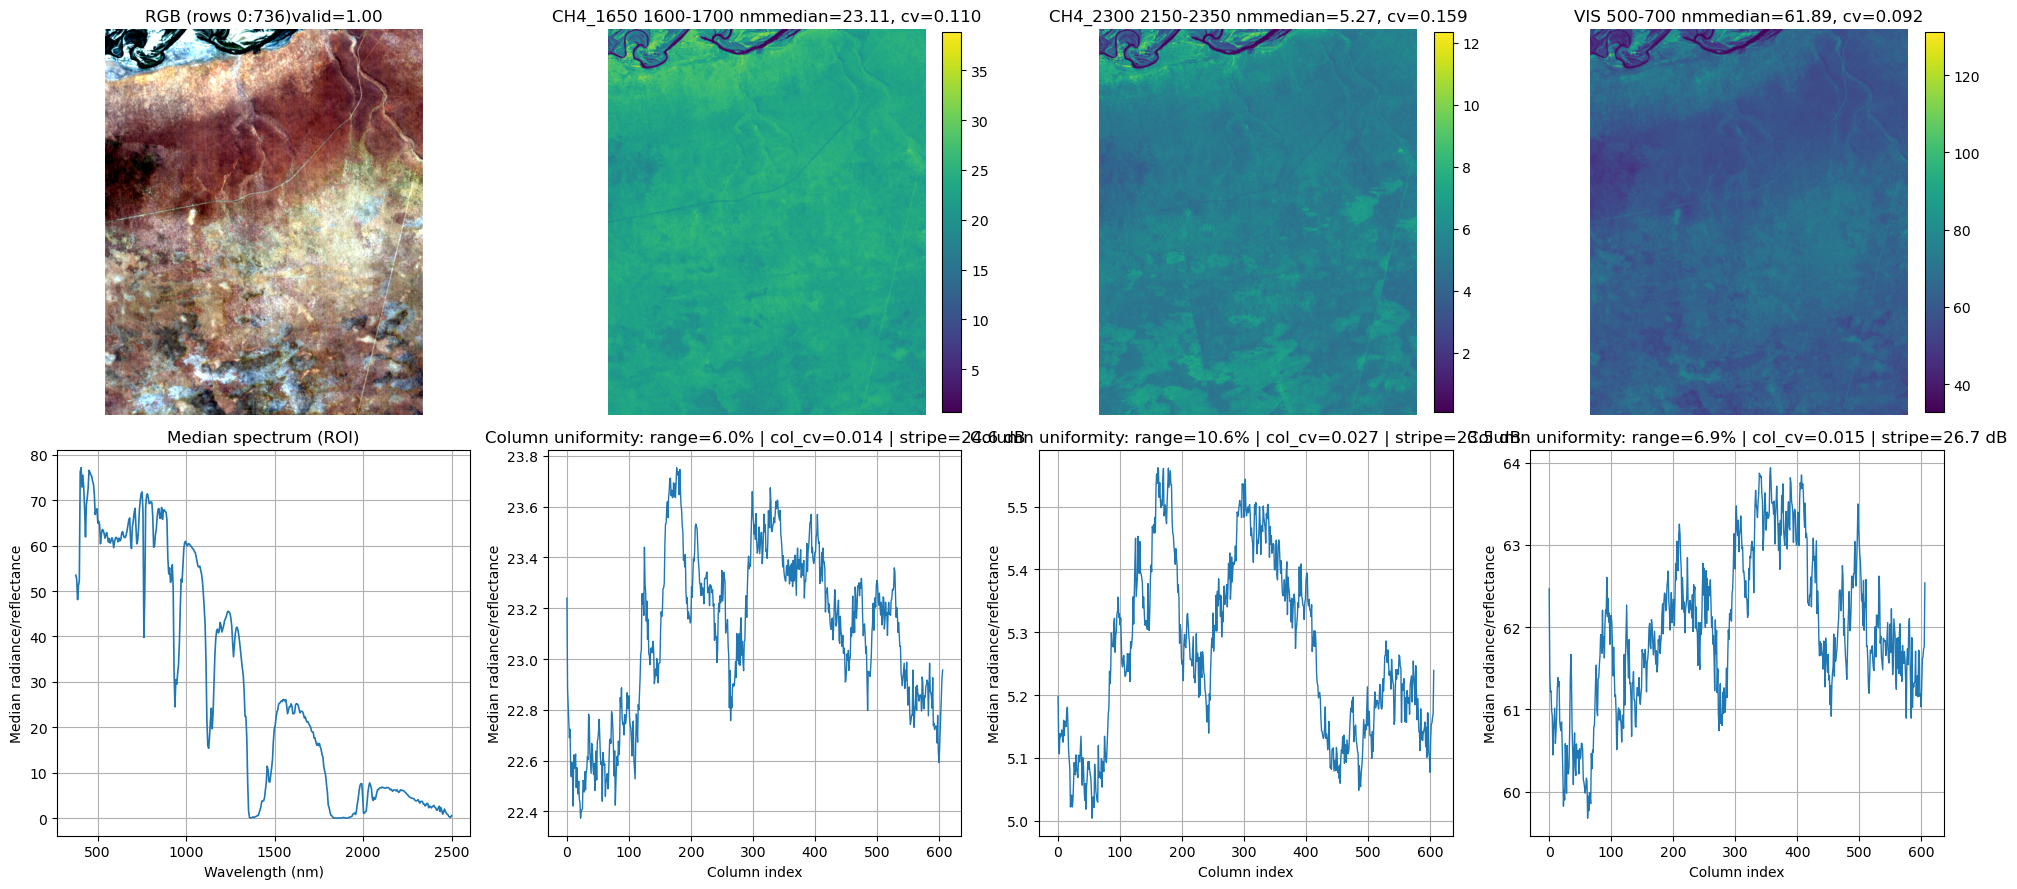

=== Senegal (0:587) ===


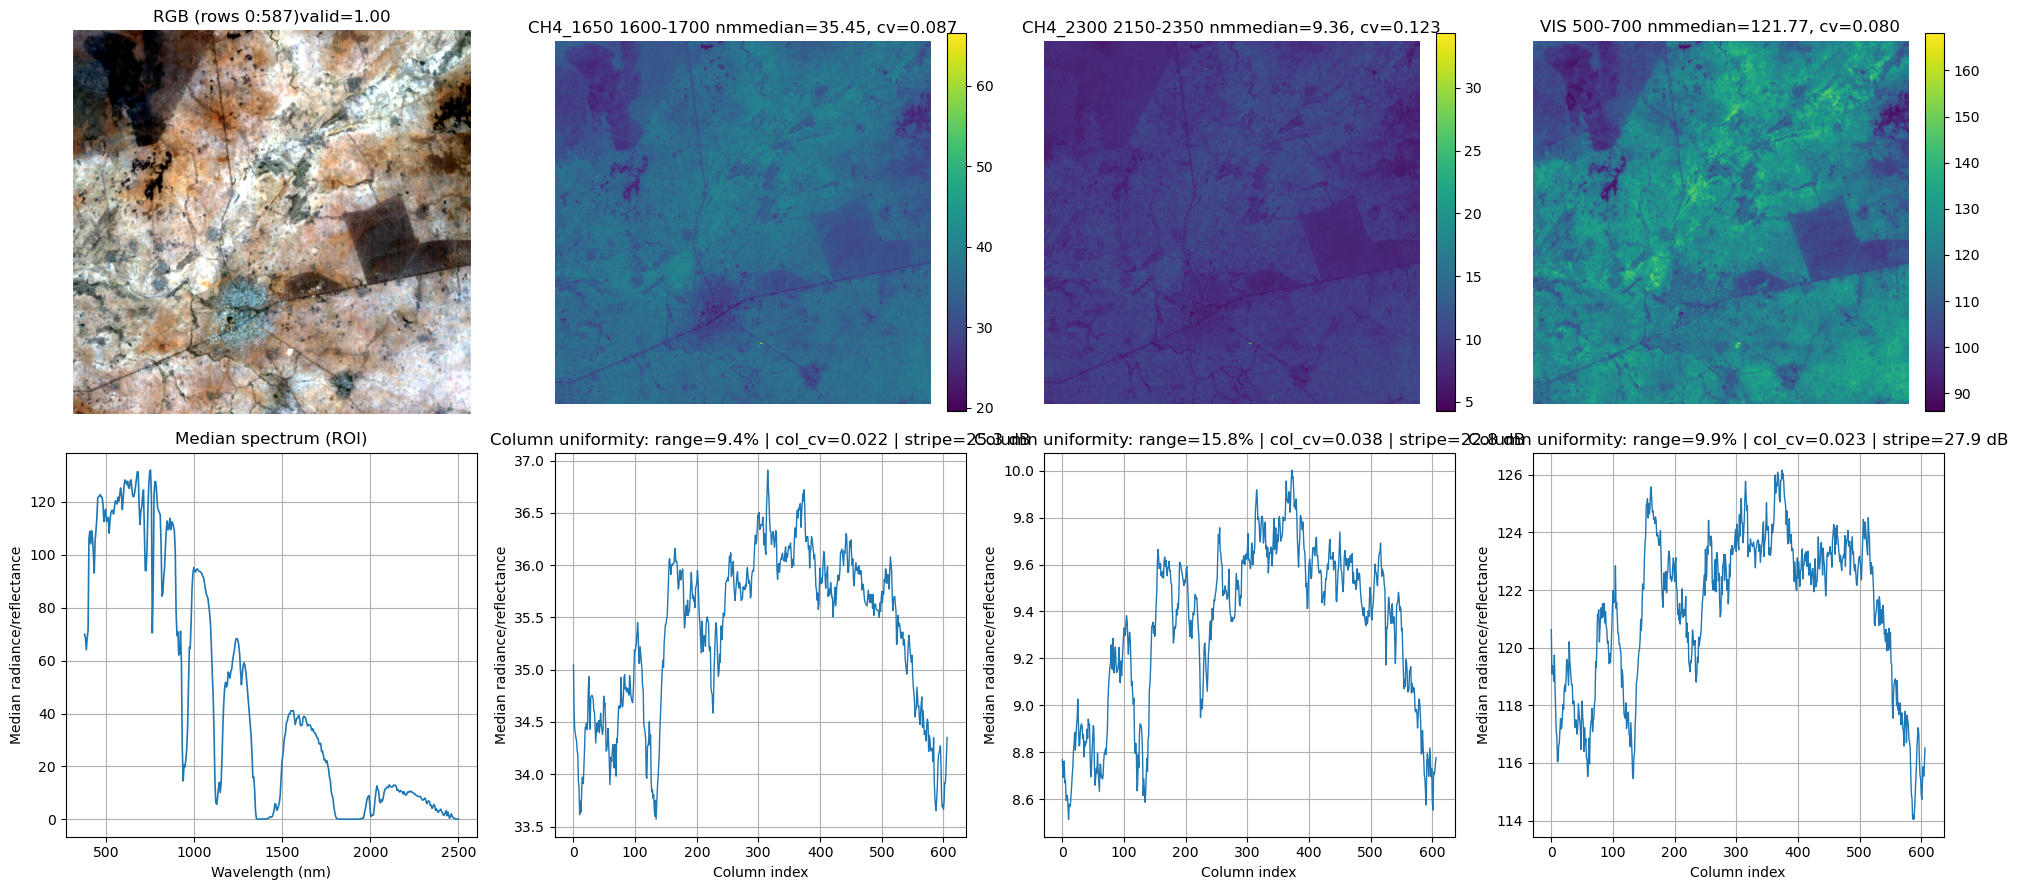

=== Sudan (0:587) ===


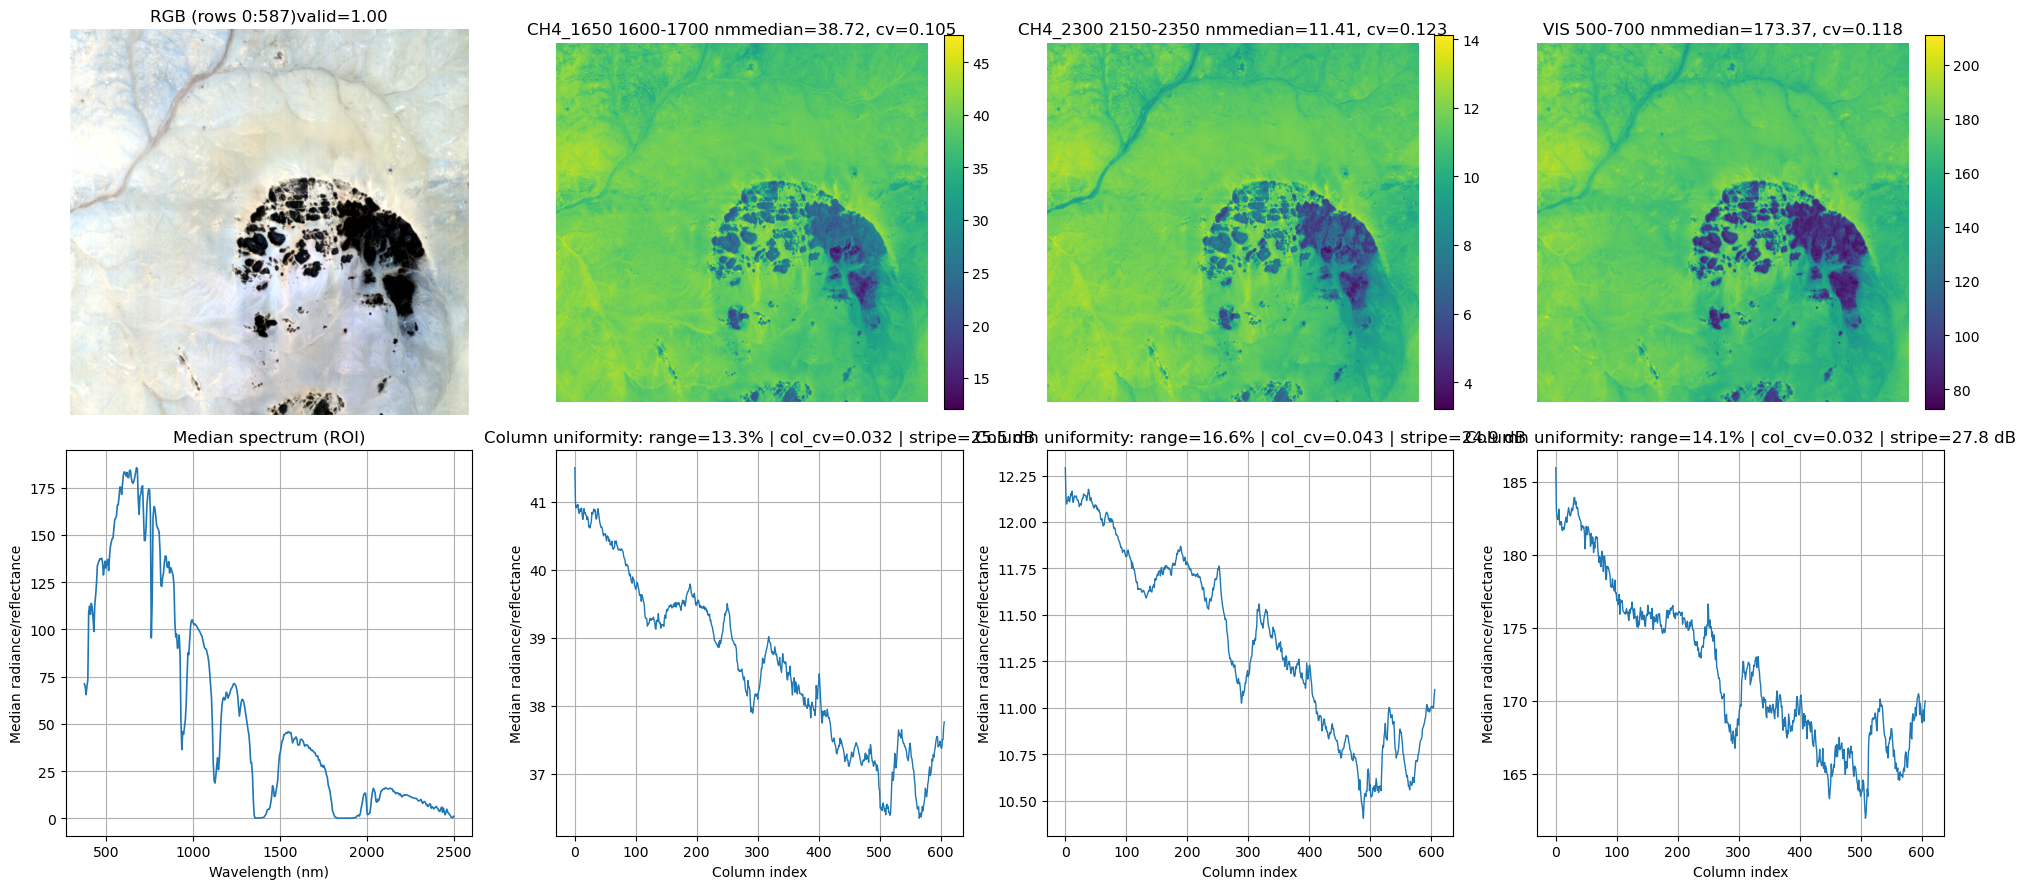

=== Yemen (0:502) ===


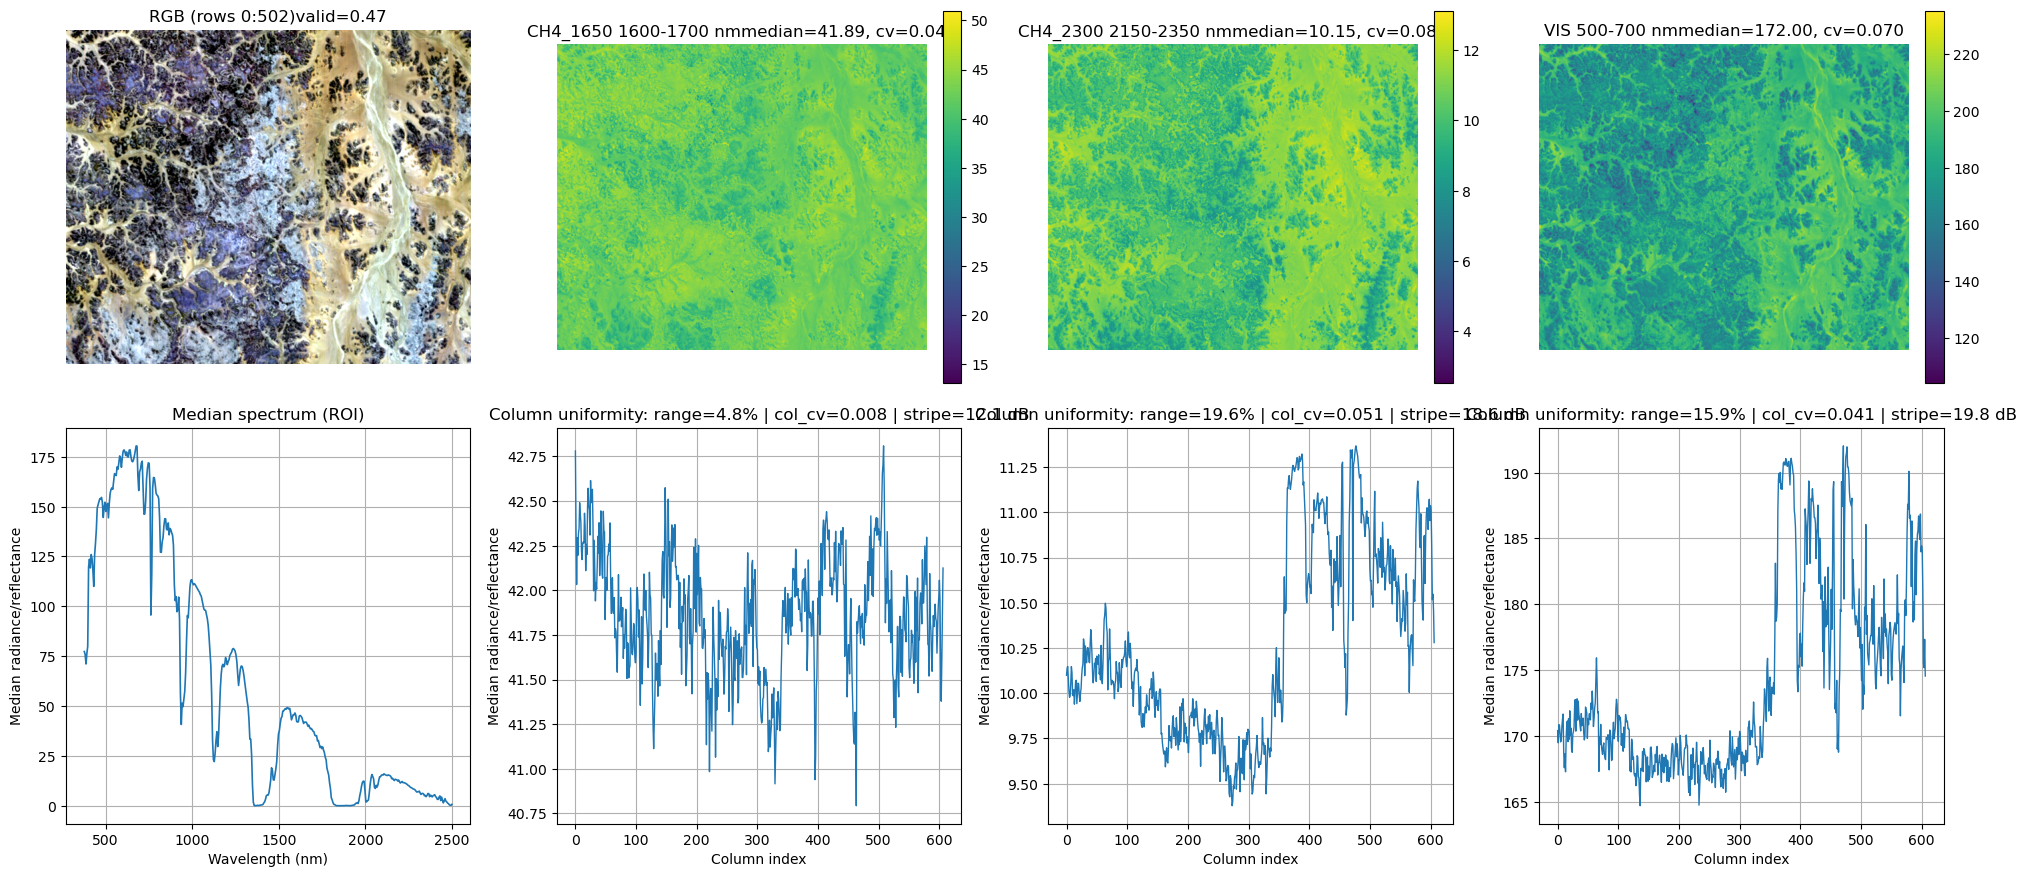

In [6]:
# --- Visual inspection: RGB, spectra, per-column profiles ------------------
for res in results:
    print(f"=== {res.name} ({res.rows_used}) ===")
    n_windows = len(res.windows)
    fig, axes = plt.subplots(2, n_windows + 1, figsize=(5 * (n_windows + 1), 9))

    # Quicklook RGB for the chosen rows
    ax_rgb = axes[0, 0]
    ax_rgb.imshow(res.rgb)
    ax_rgb.set_title(f"RGB (rows {res.rows_used})valid={res.valid_fraction:.2f}")
    ax_rgb.axis("off")

    # Median spectrum over the ROI
    ax_spec = axes[1, 0]
    if res.spectrum_wavelengths is not None:
        ax_spec.plot(res.spectrum_wavelengths, res.spectrum, lw=1.2)
        ax_spec.set_xlabel("Wavelength (nm)")
    else:
        ax_spec.plot(res.spectrum, lw=1.2)
        ax_spec.set_xlabel("Band index")
    ax_spec.set_ylabel("Median radiance/reflectance")
    ax_spec.set_title("Median spectrum (ROI)")

    # Per-window images and column profiles
    for idx, (win_name, metrics) in enumerate(res.windows.items(), start=1):
        img = metrics["image"]
        col_med = metrics["col_median"]
        peak_db = metrics["stripe_peak_db"]
        ax_img = axes[0, idx]
        im = ax_img.imshow(img, cmap="viridis")
        ax_img.set_title(
        f"{win_name} {metrics['nm_range'][0]:.0f}-{metrics['nm_range'][1]:.0f} nm"
            f"median={metrics['median']:.2f}, cv={metrics['cv']:.3f}"
        )
        ax_img.axis("off")
        fig.colorbar(im, ax=ax_img, fraction=0.046, pad=0.04)

        ax_col = axes[1, idx]
        ax_col.plot(col_med, lw=1.0)
        ax_col.set_xlabel("Column index")
        ax_col.set_ylabel("Median radiance/reflectance")
        stripe_txt = "none" if peak_db is None else f"{peak_db:.1f} dB"
        ax_col.set_title(
            f"Column uniformity: range={metrics['col_range_pct']*100:.1f}% | "
            f"col_cv={metrics['col_cv']:.3f} | stripe={stripe_txt}"
        )

    plt.tight_layout()
    plt.show()


Botswana: suggested ROW_SLICE 75:736 using CH4_2300 (median row-CV=0.1056, threshold=0.2111)


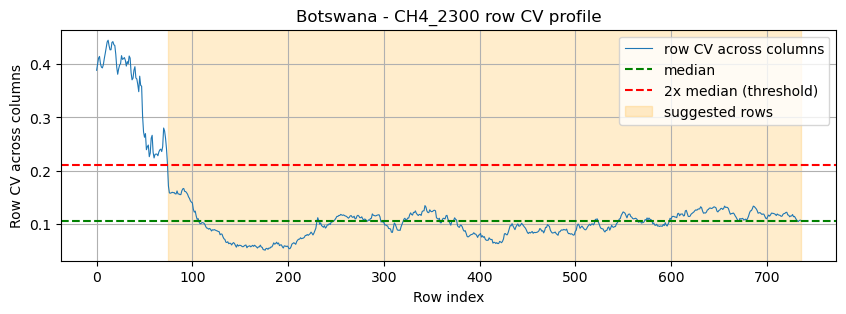

Senegal: suggested ROW_SLICE 0:587 using CH4_2300 (median row-CV=0.1291, threshold=0.2582)


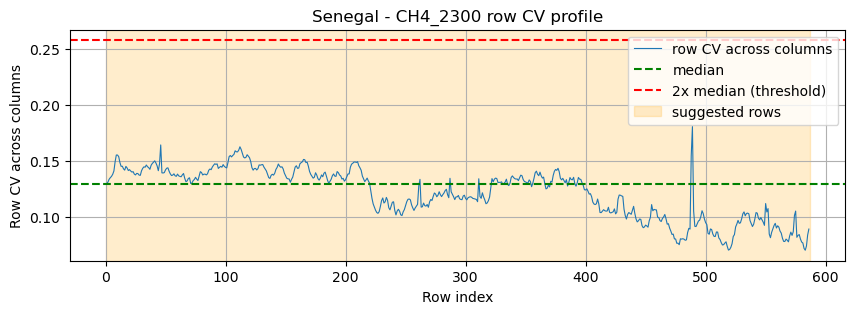

Sudan: suggested ROW_SLICE 0:264 using CH4_2300 (median row-CV=0.0824, threshold=0.1649)


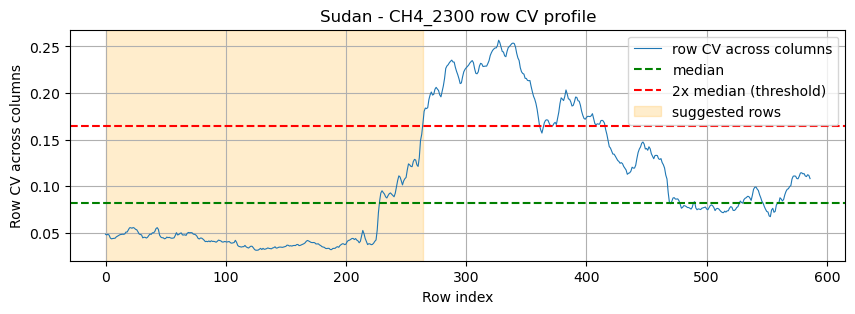

Yemen: suggested ROW_SLICE 0:502 using CH4_2300 (median row-CV=0.0778, threshold=0.1556)


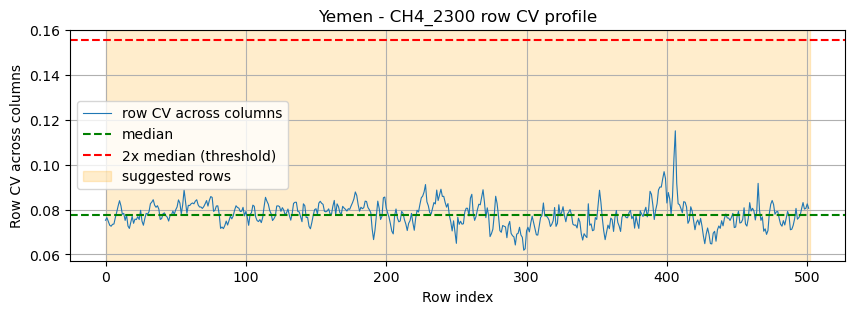

In [7]:
# --- Auto-suggest stable row block (keep all columns) ---------------------
SUGGEST_WINDOW = "CH4_2300" if "CH4_2300" in BAND_WINDOWS_NM else next(iter(BAND_WINDOWS_NM))

def longest_block_below_threshold(arr: np.ndarray, threshold: float) -> tuple[int, int]:
    best_start, best_end = 0, 0
    current_start = None
    for idx, val in enumerate(arr):
        ok = np.isfinite(val) and val <= threshold
        if ok and current_start is None:
            current_start = idx
        if (not ok or idx == len(arr) - 1) and current_start is not None:
            end_idx = idx + 1 if ok and idx == len(arr) - 1 else idx
            if end_idx - current_start > best_end - best_start:
                best_start, best_end = current_start, end_idx
            current_start = None
    return best_start, best_end

for res in results:
    if not res.windows:
        continue
    win_name = SUGGEST_WINDOW if SUGGEST_WINDOW in res.windows else list(res.windows.keys())[0]
    profile = res.windows[win_name].get("row_cv_profile")
    if profile is None:
        print(f"{res.name}: row CV profile missing for {win_name}")
        continue

    finite_profile = profile[np.isfinite(profile)]
    if finite_profile.size == 0:
        print(f"{res.name}: row CV profile empty for {win_name}")
        continue

    median_cv = float(np.nanmedian(finite_profile))
    threshold = 2.0 * median_cv  # adjustable: tighten or relax as needed
    start, stop = longest_block_below_threshold(profile, threshold)

    print(
        f"{res.name}: suggested ROW_SLICE {start}:{stop} using {win_name} "
        f"(median row-CV={median_cv:.4f}, threshold={threshold:.4f})"
    )

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(profile, lw=0.8, label="row CV across columns")
    ax.axhline(median_cv, color="green", linestyle="--", label="median")
    ax.axhline(threshold, color="red", linestyle="--", label="2x median (threshold)")
    ax.axvspan(start, stop, color="orange", alpha=0.2, label="suggested rows")
    ax.set_xlabel("Row index")
    ax.set_ylabel("Row CV across columns")
    ax.set_title(f"{res.name} - {win_name} row CV profile")
    ax.legend()
    plt.show()


### How to interpret the metrics and pick the best calibration-like scene
- Validity first: avoid scenes with low `valid_fraction` (e.g., <0.9) or obvious clouds/holes in RGB/quicklooks.
- Column homogeneity is key: use `*_col_cv` and `*_col_range_pct` (lower is better). Prioritize the 1650–1700 nm and 2150–2350 nm windows.
- Striping: prefer `*_stripe_db` near `None` or <5 dB; >8–10 dB means noticeable striping.
- Overall flatness: `*_cv` (global coefficient of variation) is a secondary tie-breaker after column metrics.
- Brightness: if homogeneity is similar, pick the higher `*_median` in CH4 windows (bright targets help SNR); avoid saturation in the window images/column profiles.
- Visual sanity: in the per-window images/column medians, good scenes look smooth with no strong gradients across columns.

Quick ranking recipe:
1) Filter scenes with `valid_fraction >= 0.9` and stripe_db < ~8 dB in CH4 windows.
2) Rank by `(CH4_2300_col_cv + CH4_1650_col_cv)` ascending.
3) Tie-break by `(CH4_2300_cv + CH4_1650_cv)` ascending, then by `CH4_2300_median` descending.

Tip: If edge rows are noisy, set `ROW_SLICE` to exclude them (keep all columns) and rerun; a robust pick should remain top after the slice.


Optional row sub-selection (keep all columns):
- Compute row-wise column CV in a clean window (e.g., 2150–2350 nm): for each row, take median across bands -> vector over columns -> CV = std/mean.
- Keep rows with row-CV below a threshold, e.g., below the 50th–75th percentile or <2× the median row-CV. Then set `ROW_SLICE` accordingly (contiguous rows covering the stable block).
- Re-run the notebook with the chosen `ROW_SLICE`; the top scene should remain the best after this refinement.
